### **0. Import libraries**

In [1]:
import pandas as pd
from datetime import datetime
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.tools.tools import add_constant
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from xgboost import XGBRegressor
from scipy.special import huber
import numpy as np
import seaborn as sns
from statsmodels.tools.tools import maybe_unwrap_results
from statsmodels.graphics.gofplots import ProbPlot
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
from multiprocessing import Manager
from multiprocessing.pool import Pool
import time
import os
RANDOM_STATE = 2023
TEST_SIZE = 0.2

In [2]:
# from google.colab import drive
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# drive.mount('/content/drive')
# file_path = '/content/drive/MyDrive/Colab Notebooks/'
file_path = './../'

### **1. Load data**

In [3]:
raw = pd.read_csv(file_path+'final_df_2.csv').iloc[:,1:]
print('Dataframe shape: ',raw.shape)
print('Dataframe info: ',raw.info())
display(raw.head(2))

Dataframe shape:  (553240, 34)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 553240 entries, 0 to 553239
Data columns (total 34 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   ZCTA                               553240 non-null  int64  
 1   year_month                         553240 non-null  int64  
 2   ins_1_no_bin_raw                   553240 non-null  float64
 3   ins_2_add_acres_raw                553240 non-null  float64
 4   ins_3_norms                        553239 non-null  float64
 5   ins_4_add_acres_norms              553239 non-null  float64
 6   ins_5_norm_bins_acres              553239 non-null  float64
 7   ins_6_bins_raw                     553240 non-null  float64
 8   zip_pm25                           546132 non-null  float64
 9   zip_elevation                      550211 non-null  float64
 10  elevation_difference               435467 non-null  float64
 11  zip_wspd

,ZCTA,year_month,ins_1_no_bin_raw,ins_2_add_acres_raw,ins_3_norms,ins_4_add_acres_norms,ins_5_norm_bins_acres,ins_6_bins_raw,zip_pm25,zip_elevation,...,percent_pop_male_age_under_5,total_population,percent_bach_deg_grad_new,percent_high_school_grad_new,percent_pop_age_15to19_new,percent_pop_female_age_15to19_new,percent_pop_male_age_10to14_new,percent_pop_male_age_15to19_new,Patient_disease,total_cases
0,89010,199101,0.014313,2.171619,2.095820,0.001013,0.011318,24.261588,12.450976,4784.0,...,2.4,275.6,14.272763,56.603842,13.526364,14.514991,3.99958,8.781446,NaN,NaN
1,89010,199102,0.003401,1.473353,0.499474,0.000688,0.007878,16.875655,11.255854,4784.0,...,2.4,275.6,14.272763,56.603842,13.526364,14.514991,3.99958,8.781446,NaN,NaN


In [4]:
raw_expm25 = raw.loc[~raw['zip_pm25'].isna()].copy()
print('Dataframe info: ',raw_expm25.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 546132 entries, 0 to 553239
Data columns (total 34 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   ZCTA                               546132 non-null  int64  
 1   year_month                         546132 non-null  int64  
 2   ins_1_no_bin_raw                   546132 non-null  float64
 3   ins_2_add_acres_raw                546132 non-null  float64
 4   ins_3_norms                        546131 non-null  float64
 5   ins_4_add_acres_norms              546131 non-null  float64
 6   ins_5_norm_bins_acres              546131 non-null  float64
 7   ins_6_bins_raw                     546132 non-null  float64
 8   zip_pm25                           546132 non-null  float64
 9   zip_elevation                      546132 non-null  float64
 10  elevation_difference               432233 non-null  float64
 11  zip_wspd                           5461

In [5]:
raw.loc[~raw['households_count'].isna()]['ZCTA'].nunique()

1612

In [6]:
raw_stage1 = raw_expm25.loc[~raw_expm25['households_count'].isna()].copy()
print('Dataframe info: ',raw_stage1.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 538810 entries, 0 to 553239
Data columns (total 34 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   ZCTA                               538810 non-null  int64  
 1   year_month                         538810 non-null  int64  
 2   ins_1_no_bin_raw                   538810 non-null  float64
 3   ins_2_add_acres_raw                538810 non-null  float64
 4   ins_3_norms                        538810 non-null  float64
 5   ins_4_add_acres_norms              538810 non-null  float64
 6   ins_5_norm_bins_acres              538810 non-null  float64
 7   ins_6_bins_raw                     538810 non-null  float64
 8   zip_pm25                           538810 non-null  float64
 9   zip_elevation                      538810 non-null  float64
 10  elevation_difference               426549 non-null  float64
 11  zip_wspd                           5388

In [7]:
#TO REMOVE AFTER I GET MORE COMPUTING POWER
# raw_stage1 = raw_stage1.loc[raw_stage1.ZCTA.isin(list(raw_stage1.ZCTA.unique()[:3]))]
# raw_stage1.shape

### **2. Feature engineering**

In [8]:
#look at stats first
raw_stage1.describe()

,ZCTA,year_month,ins_1_no_bin_raw,ins_2_add_acres_raw,ins_3_norms,ins_4_add_acres_norms,ins_5_norm_bins_acres,ins_6_bins_raw,zip_pm25,zip_elevation,...,percent_pop_male_age_5to9,percent_pop_male_age_under_5,total_population,percent_bach_deg_grad_new,percent_high_school_grad_new,percent_pop_age_15to19_new,percent_pop_female_age_15to19_new,percent_pop_male_age_10to14_new,percent_pop_male_age_15to19_new,total_cases
count,538810.000000,538810.000000,538810.000000,538810.000000,538810.000000,538810.000000,538810.000000,5.388100e+05,538810.000000,538810.000000,...,538810.000000,538810.000000,538810.000000,538810.000000,538810.000000,538810.000000,538810.000000,538810.000000,538810.000000,88349.000000
mean,93654.074813,200455.386166,0.080885,180.651835,12.646169,0.084870,0.921501,1.960948e+03,10.239111,1279.671586,...,7.125112,7.650424,20990.817317,25.066083,75.274736,7.672503,7.270102,6.955415,5.993639,1.029463
std,1823.364933,807.391308,0.180290,692.157322,476.046405,0.480308,5.327597,7.417969e+03,5.976578,1724.789214,...,3.888841,4.483334,20757.020751,16.911635,17.378581,4.059371,4.725894,4.293331,3.927259,0.172677
min,89010.000000,199101.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,-230.000000,...,0.000000,0.000000,2.000000,0.010000,0.486379,0.010000,0.010000,0.010000,0.010000,1.000000
25%,92258.000000,199712.000000,0.000881,0.032698,0.128314,0.000015,0.000184,3.978730e-01,6.012111,143.000000,...,5.000000,5.000000,1729.300000,12.085806,68.894423,5.360227,4.874479,4.854490,4.089742,1.000000
50%,93647.000000,200412.000000,0.018668,6.377243,2.744359,0.002965,0.033147,7.130964e+01,8.819501,503.000000,...,6.900000,7.200000,16241.000000,20.833634,80.708626,7.331364,6.643380,6.659300,5.653644,1.000000
75%,95377.000000,201112.000000,0.085261,106.090639,12.571746,0.049437,0.550448,1.180939e+03,13.105340,1619.000000,...,8.600000,9.400000,34698.500000,34.811141,87.473210,9.302500,8.677616,8.369120,7.217545,1.000000
max,97635.000000,201812.000000,59.096422,125873.289036,348158.983667,258.866251,2951.697056,1.391002e+06,88.450000,10572.000000,...,44.700000,81.300000,109414.000000,95.000000,95.000000,68.718182,75.011415,95.000000,95.000000,4.000000


In [9]:
#make year values smaller
raw_stage1['year_trend'] = raw_stage1.apply(lambda x: x['year'] - (raw_stage1['year'].min()-1),axis=1)

#minmax scaling for elevation - elastic net sensitive to variables on different scales
elevation = MinMaxScaler().fit_transform(np.array(raw_stage1['elevation_difference']).reshape(-1,1))
raw_stage1['s_elevation_difference'] = elevation.reshape(elevation.shape[0],)

# #OHE  for month
raw_stage1['month'] = raw_stage1['year_month'].astype(str).apply(lambda x: x[-2:])
mth_enc = OneHotEncoder(handle_unknown='error',drop='first',sparse=False) 
mth_ohc_values = mth_enc.fit_transform(np.array(raw_stage1['month']).reshape(-1,1))
mth_ohc_labels = mth_enc.get_feature_names_out(['month'])
raw_stage1 = pd.concat([raw_stage1.reset_index(drop=True), pd.DataFrame(mth_ohc_values, columns = mth_ohc_labels).reset_index(drop=True)],axis=1)
print(mth_ohc_labels)

# #OHE for ZCTA
zc_enc = OneHotEncoder(handle_unknown='error',drop='first',sparse=False) 
zc_ohc_values = zc_enc.fit_transform(np.array(raw_stage1['ZCTA']).reshape(-1,1))
zc_ohc_labels = zc_enc.get_feature_names_out(['ZCTA'])
raw_stage1 = pd.concat([raw_stage1.reset_index(drop=True), pd.DataFrame(zc_ohc_values, columns = zc_ohc_labels).reset_index(drop=True)],axis=1)
print(zc_ohc_labels)

['month_02' 'month_03' 'month_04' 'month_05' 'month_06' 'month_07'
 'month_08' 'month_09' 'month_10' 'month_11' 'month_12']
['ZCTA_89019' 'ZCTA_89060' 'ZCTA_89061' ... 'ZCTA_96150' 'ZCTA_96161'
 'ZCTA_97635']


In [10]:
raw_stage1.shape

(538810, 1646)

In [11]:
raw_stage1.head(2)

,ZCTA,year_month,ins_1_no_bin_raw,ins_2_add_acres_raw,ins_3_norms,ins_4_add_acres_norms,ins_5_norm_bins_acres,ins_6_bins_raw,zip_pm25,zip_elevation,...,ZCTA_96140,ZCTA_96141,ZCTA_96142,ZCTA_96143,ZCTA_96145,ZCTA_96146,ZCTA_96148,ZCTA_96150,ZCTA_96161,ZCTA_97635
0,89010,199101,0.014313,2.171619,2.095820,0.001013,0.011318,24.261588,12.450976,4784.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,89010,199102,0.003401,1.473353,0.499474,0.000688,0.007878,16.875655,11.255854,4784.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
raw_stage1.columns

Index(['ZCTA', 'year_month', 'ins_1_no_bin_raw', 'ins_2_add_acres_raw',
       'ins_3_norms', 'ins_4_add_acres_norms', 'ins_5_norm_bins_acres',
       'ins_6_bins_raw', 'zip_pm25', 'zip_elevation',
       ...
       'ZCTA_96140', 'ZCTA_96141', 'ZCTA_96142', 'ZCTA_96143', 'ZCTA_96145',
       'ZCTA_96146', 'ZCTA_96148', 'ZCTA_96150', 'ZCTA_96161', 'ZCTA_97635'],
      dtype='object', length=1646)

In [13]:
#create data
def create_stage1_data(instrument_var_name):
  #list variables
  stage_1_yvar  = 'zip_pm25'
  time_vars = ['year_trend'] + list(mth_ohc_labels)
  iv_vars =  [instrument_var_name] #['ins_1_no_bin_raw', 'ins_2_add_acres_raw','ins_3_norms', 'ins_4_add_acres_norms', 'ins_5_norm_bins_acres','ins_6_bins_raw']
  env_vars = ['s_elevation_difference']
  dem_vars = [ 
          'total_population','households_count',
          'median_income_per_household', 'percent_high_school_grad_new', 'percent_bach_deg_grad_new', 
          'percent_pop_age_under_5', 'percent_pop_age_5to9', 'percent_pop_age_10to14','percent_pop_age_15to19_new',
          # 'percent_pop_male_age_under_5', 'percent_pop_male_age_5to9', 'percent_pop_male_age_10to14_new', 'percent_pop_male_age_15to19_new'
          'percent_pop_female_age_under_5', 'percent_pop_female_age_5to9','percent_pop_female_age_10to14', 'percent_pop_female_age_15to19_new'] #PENDING

  stage_1_xvars = time_vars + iv_vars + env_vars + dem_vars + list(zc_ohc_labels)

  X = raw_stage1[stage_1_xvars]
  y = raw_stage1[stage_1_yvar]

  return X, y

In [14]:
def train_test_panel_split(X,y,test_size=TEST_SIZE):
  #split into train vs test
  last_train_idx = round(X.shape[0]*(1-test_size))

  X_train = X.iloc[:last_train_idx] 
  X_test = X.iloc[last_train_idx:]

  y_train = y.iloc[:last_train_idx]
  y_test = y.iloc[last_train_idx:]
  
  return X_train, X_test, y_train, y_test


In [15]:
#actual code for featuregeneration
instruments = ['ins_5_norm_bins_acres','ins_6_bins_raw']
# X, y = create_stage1_data(instrument_var_name=instruments[4])
# X_train, X_test, y_train, y_test = train_test_panel_split(X,y)

### **3. Model selection**

In [16]:
#Define loss functions

## ADJUST FOR CLUSTER STD ERRORS

def get_rmse(model,X,y):
    return ((np.array(y) - model.predict(X))**2).mean()    

def get_mae(model,X,y):
    return (abs(np.array(y) - model.predict(X))).mean()    

def get_huber_loss(model,X,y,delta=5):
    r = np.array(y) - model.predict(X)
    return sum(huber(delta,r))

In [17]:
import multiprocessing
multiprocessing.cpu_count()

48

In [18]:
#Define hyperparmeters
hyperparams = {'booster':'gbtree', 
               'objective':'reg:squarederror', 
               'tree_method':'hist', 
               'nthread':48,
               # 'early_stopping_rounds':10,
               # 'n_jobs':2,
               'gamma':0,
               'eval_metric':'rmse',
               'num_parallel_tree':20,         #number of trees to be running in the model
               'max_depth' : [6,12,18],         #max tree depth
               'subsample':[0.6],       #proportion of training instances subsampled
               'reg_lambda':[0.01, 0.1, 1],     #L2 reg
               'learning_rate': [0.03],
               'random_state' :RANDOM_STATE
              }
       #,
keys = list(hyperparams.keys())
hyperparams_df = pd.DataFrame(np.array(np.meshgrid(*[hyperparams[key_i] for key_i in keys])).T.reshape(-1, len(keys)))
hyperparams_df.columns = keys 
hyperparams_df.head()

,booster,objective,tree_method,nthread,gamma,eval_metric,num_parallel_tree,max_depth,subsample,reg_lambda,learning_rate,random_state
0,gbtree,reg:squarederror,hist,48,0,rmse,20,6,0.6,0.01,0.03,2023
1,gbtree,reg:squarederror,hist,48,0,rmse,20,12,0.6,0.01,0.03,2023
2,gbtree,reg:squarederror,hist,48,0,rmse,20,18,0.6,0.01,0.03,2023
3,gbtree,reg:squarederror,hist,48,0,rmse,20,6,0.6,0.1,0.03,2023
4,gbtree,reg:squarederror,hist,48,0,rmse,20,12,0.6,0.1,0.03,2023


In [71]:
def select_models(hyperparams_df,X_train,y_train,results_filename):
    results = {'hyperparams':[], 'rmse_train': [], 'rmse_test': []}

    folds = TimeSeriesSplit(n_splits=5) #default value

    #implement grid search
    for i in tqdm(range(hyperparams_df.shape[0]), leave=False): #to use fullhyperparamset for actual run
        result_file = pd.read_csv(results_filename)
        
        if i in result_file['hyperparam_id'].tolist():
            continue
        
        #get hyperparams
        hyperparams = dict(hyperparams_df.iloc[i])

        #initialize empty lists
        rmse_trains =[]; rmse_tests =[]; 
        # huber_trains=[]; huber_tests=[]   #we should care more about squared errors because "outliers" arising from wildfires are a big part of what we are trying to predict.

        for fold_count,fold in enumerate(folds.split(X_train)):
            # print(fold_count)
            #get data
            X_cvtrain = X_train.loc[fold[0]]  ; X_val = X_train.loc[fold[1]]
            y_cvtrain = y_train.loc[fold[0]]  ; y_val = y_train.loc[fold[1]]
            
            # print(X_cvtrain.shape)

            #fit model
            tmp_model = XGBRegressor(**hyperparams).fit(X_cvtrain,y_cvtrain,verbose=0)  
            # print(get_rmse(tmp_model, X_cvtrain, y_cvtrain))
            #append results
            rmse_trains.append(get_rmse(tmp_model, X_cvtrain, y_cvtrain))
            rmse_tests.append(get_rmse(tmp_model, X_val, y_val))
            # huber_trains.append(get_huber_loss(tmp_model, X_cvtrain, y_cvtrain))  
            # huber_tests.append(get_huber_loss(tmp_model, X_val  , y_val))

        new_row = pd.Series({'instrument':results_filename[:-16],
                            'hyperparam_id':i,
                            'rmse_train':np.mean(rmse_trains),
                            'rmse_test':np.mean(rmse_tests)})
        
        result_file = pd.concat([result_file, new_row.to_frame().T], ignore_index=True)
        result_file.to_csv(results_filename,index=False)
        
        # display(result_file)
        
        # results['hyperparams'].append(hyperparams)
        # results['rmse_train'].append(np.mean(rmse_trains))
        # results['rmse_test'].append(np.mean(rmse_tests))
        
        # results['huber_loss_train'].append(np.mean(huber_trains))
        # results['huber_loss_test'].append(np.mean(huber_tests))
    result_file = pd.read_csv(results_filename)
    best_hyperparams = dict(hyperparams_df.iloc[result_file.sort_values('rmse_test',ascending=True).iloc[0]['hyperparam_id']])   #i])
    return best_hyperparams, result_file.sort_values('rmse_test',ascending=True)


In [72]:
#create models for each instrument and save model output
instruments = ['ins_5_norm_bins_acres','ins_6_bins_raw']
# instruments = ['ins_2_add_acres_raw']

models = dict()
print(instruments)
train_rmses = [] ; test_rmses = []
train_maes = []  ; test_maes  = []

for i in tqdm(range(len(instruments)),leave=True):
  #load data with correct instrument name
  print ('starting for instrument {}:'.format(instruments[i]))
  X, y = create_stage1_data(instrument_var_name=instruments[i])
  X_train, X_test, y_train, y_test = train_test_panel_split(X,y)

  #create csv to store hyperparameter tuning results for each instrument
  results_filename = instruments[i]+'_hyperparams.csv'
  
  if not(os.path.exists(results_filename)):
    print('True')
    instrument_df = pd.DataFrame({'instrument':[],'hyperparam_id':[],'rmse_train':[],'rmse_test':[]})
    instrument_df.to_csv(results_filename,index=False)
    
  #select and train best performing cross validated model
  best_hyperparams, results = select_models(hyperparams_df,X_train,y_train,results_filename) 
  print(best_hyperparams)
  models['stage1_xgb_model_'+str(i+1)] = XGBRegressor(**best_hyperparams).fit(X_train,y_train,verbose=0)

  #save model
  filename = file_path+'stage1_xgb_model_'+instruments[i] + '.json'
  models['stage1_xgb_model_'+str(i+1)].save_model(filename) 

  #save train and test rmses / maes
  train_rmses.append(get_rmse(models['stage1_xgb_model_'+str(i+1)],X_train,y_train))
  test_rmses.append( get_rmse(models['stage1_xgb_model_'+str(i+1)],X_test,y_test) )

  train_maes.append( get_mae(models['stage1_xgb_model_'+str(i+1)],X_train,y_train) )
  test_maes.append( get_mae(models['stage1_xgb_model_'+str(i+1)],X_test,y_test))

all_results = pd.DataFrame(
    {
      'model_name': ['stage1_xgb_model_'+str(i+1) for i in range(len(instruments))],
      'train_rmse': train_rmses, 'test_rmse': test_rmses, 
      'train_mae': train_maes, 'test_mae': test_maes
    }
)

all_results.to_csv(file_path+'stage1_xgb_model_results.csv')

['ins_5_norm_bins_acres', 'ins_6_bins_raw']


  0%|          | 0/2 [00:00<?, ?it/s]

starting for instrument ins_5_norm_bins_acres:
True



100%|██████████| 9/9 [4:42:36<00:00, 2044.14s/it]
                                                 

{'booster': 'gbtree', 'objective': 'reg:squarederror', 'tree_method': 'hist', 'nthread': '48', 'gamma': '0', 'eval_metric': 'rmse', 'num_parallel_tree': '20', 'max_depth': '18', 'subsample': '0.6', 'reg_lambda': '1.0', 'learning_rate': '0.03', 'random_state': '2023'}


 50%|█████     | 1/2 [5:00:11<5:00:11, 18011.72s/it]

starting for instrument ins_6_bins_raw:
True



100%|██████████| 9/9 [4:42:40<00:00, 2033.08s/it]
                                                 

{'booster': 'gbtree', 'objective': 'reg:squarederror', 'tree_method': 'hist', 'nthread': '48', 'gamma': '0', 'eval_metric': 'rmse', 'num_parallel_tree': '20', 'max_depth': '18', 'subsample': '0.6', 'reg_lambda': '1.0', 'learning_rate': '0.03', 'random_state': '2023'}


100%|██████████| 2/2 [10:00:14<00:00, 18007.06s/it] 


In [73]:
# results = []
# num_threads = [1, 2, 3, 4, 8, 16]
# for n in num_threads:
#     start = time.time()
#     # model = XGBRegressor(
#     #         booster='gbtree',
#     #         objective= 'reg:squarederror',
#     #         # tree_method= 'gpu_hist',
#     #         gamma= '0',
#     #         eval_metric= 'rmse',
#     #         num_parallel_tree= '20',
#     #         max_depth='18',
#     #         subsample= '0.2',
#     #         reg_lambda= '0.01',
#     #         learning_rate= '0.01',nthread=n)
#     model = XGBRegressor(**dict(hyperparams_df.iloc[0]))
#     model.fit(X_train, y_train)
#     elapsed = time.time() - start
#     print(n, elapsed)
#     results.append(elapsed)
    
# print (results)

In [74]:
best_hyperparams


{'booster': 'gbtree',
 'objective': 'reg:squarederror',
 'tree_method': 'hist',
 'nthread': '48',
 'gamma': '0',
 'eval_metric': 'rmse',
 'num_parallel_tree': '20',
 'max_depth': '18',
 'subsample': '0.6',
 'reg_lambda': '1.0',
 'learning_rate': '0.03',
 'random_state': '2023'}

In [75]:
model.get_params()

NameError: name 'model' is not defined

In [ ]:
dict(zip(num_threads,results))

In [ ]:
#analyze best hyperparams for each model config
best_hyperparams_all_models = [model.get_xgb_params() for model in models.values()]

for idx, name in enumerate(models.keys()):
  best_hyperparams_all_models[idx]['model_name'] = name 

best_hyperparams_all_models_df = pd.DataFrame(best_hyperparams_all_models)

final_results = pd.merge(best_hyperparams_all_models_df[['model_name']+list(hyperparams.keys())],
                         all_results ,
                         how='left', 
                         on='model_name')

display(final_results)

### **4. Model evaluation**

#### 4a. RMSEs

In [ ]:
#see above. 

#### 4b. MAEs

In [ ]:
#see above.

#### 4c. Adj. R-squared

In [ ]:
#not applicable for non-linear models.

### **5. Feature importances / inference**

In [58]:
ls 

1.0-jam-wind-cleaning.ipynb
1.1-jam-wind-direction.ipynb
1.2-jam-wind-functions.ipynb
1.4-jam-wind_fire_centroids.ipynb
3.0-jmm-fires_cleaning.ipynb
3.1-jmm-fires_clean_eda.ipynb
3.2-jmm-fires_dropped_eda.ipynb
3.3-jam-fire_zcta_add.ipynb
3.4-jam-fires_final_stage_cleaning_zctas.ipynb
3.5-jam-fire-trim-multipolygons.ipynb
4.0-jam-join_data.ipynb
4.1-jam-join_data_instrument_1.ipynb
4.2-jam-join_data_instrument_2.ipynb
4.3-jam-join_data_instrument_troubleshooting.ipynb
4.4-jam-lookups.ipynb
4.5_jam_lookups_LK.ipynb
4.6_jam_fire_wspd.ipynb
5.0-jam-instrument_revision.ipynb
5.1-jam-instrument-2.ipynb
5.2-jam-instrument-3-all.ipynb
5.3_jam_aggregation.ipynb
5.4_jam_final_join.ipynb
5.5_jam_tests_join.ipynb
6.0-lk-cross_sectional_models.ipynb
7.0-phd-fake_med_data_zipcode.ipynb
Deep_OLS.ipynb
SatAM.ipynb
Stage1ModelsPDv1.ipynb
Stage1_revised_for_Jordan.ipynb
Stage1_revised_for_Jordan_v2.ipynb
final_df_2.csv
ins_5_norm_bins_acres_hyperparams.csv
ins_6_bins_raw_hyperparams.csv
stage1_xgb_mode

In [74]:
#code for loading xgb model object
instrument_choice = "ins_4_add_acres_norms"

best_xgb_model = XGBRegressor()
best_xgb_model.load_model('stage1_xgb_model_{}.json'.format(str(instrument_choice)))

XGBoostError: [14:40:51] ../src/common/json.cc:407: Unknown construct, around character position: 5242880
    ,-1,528,,1.61328
    ~~~~~~~^~~~~~~~~
Stack trace:
  [bt] (0) /home/ec2-user/anaconda3/lib/python3.9/site-packages/xgboost/lib/libxgboost.so(+0x197383) [0x7f230d197383]
  [bt] (1) /home/ec2-user/anaconda3/lib/python3.9/site-packages/xgboost/lib/libxgboost.so(+0x199f1f) [0x7f230d199f1f]
  [bt] (2) /home/ec2-user/anaconda3/lib/python3.9/site-packages/xgboost/lib/libxgboost.so(+0x19a3bd) [0x7f230d19a3bd]
  [bt] (3) /home/ec2-user/anaconda3/lib/python3.9/site-packages/xgboost/lib/libxgboost.so(+0x19a658) [0x7f230d19a658]
  [bt] (4) /home/ec2-user/anaconda3/lib/python3.9/site-packages/xgboost/lib/libxgboost.so(+0x19a42d) [0x7f230d19a42d]
  [bt] (5) /home/ec2-user/anaconda3/lib/python3.9/site-packages/xgboost/lib/libxgboost.so(+0x19e300) [0x7f230d19e300]
  [bt] (6) /home/ec2-user/anaconda3/lib/python3.9/site-packages/xgboost/lib/libxgboost.so(+0x19a41f) [0x7f230d19a41f]
  [bt] (7) /home/ec2-user/anaconda3/lib/python3.9/site-packages/xgboost/lib/libxgboost.so(+0x19a658) [0x7f230d19a658]
  [bt] (8) /home/ec2-user/anaconda3/lib/python3.9/site-packages/xgboost/lib/libxgboost.so(+0x19a42d) [0x7f230d19a42d]



In [71]:
from xgboost import XGBRegressor
# from google.colab import drive
XGBRegressor.__version__
# drive.mount('/content/drive')
# file_path = '/content/drive/MyDrive/capstone_fire/models/stage1_xgb/'

instruments = ['ins_1_no_bin_raw', 'ins_2_add_acres_raw','ins_3_norms', 'ins_4_add_acres_norms', 'ins_5_norm_bins_acres','ins_6_bins_raw']
instrument_choice = instruments[4]

best_xgb_model = XGBRegressor()
best_xgb_model.load_model('stage1_xgb_model_{}.json'.format(str(instrument_choice)))

AttributeError: type object 'XGBRegressor' has no attribute '__version__'

#### 5a. Built-in

In [23]:
feature_category_dict = {'year_trend':'year', 
                         's_elevation_difference':'elevation'}  #check if need to remove elevation

for i in list(mth_ohc_labels): 
  feature_category_dict[i]='month'

for i in list(zc_ohc_labels): 
  feature_category_dict[i]='geography'

for i in ['ins_5_norm_bins_acres','ins_6_bins_raw']:
  feature_category_dict[i]='instrument'

for i in ['total_population','households_count','percent_pop_age_under_5', 'percent_pop_age_5to9', 'percent_pop_age_10to14','percent_pop_age_15to19_new']:
  feature_category_dict[i]='population'

for i in ['mean_income_per_household','median_income_per_household','percent_high_school_grad_new','percent_bach_deg_grad_new']:
  feature_category_dict[i]='social.status'

for i in ['percent_pop_female_age_under_5', 'percent_pop_female_age_5to9','percent_pop_female_age_10to14', 'percent_pop_female_age_15to19_new']:
  feature_category_dict[i]='gender'
  

<AxesSubplot:title={'center':'importance'}, xlabel='[category]'>

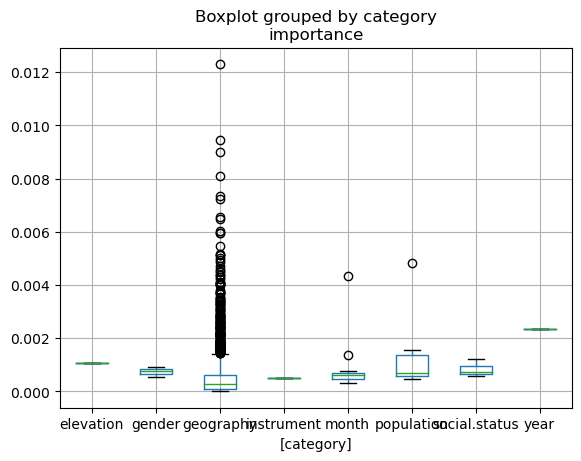

In [24]:
importances = pd.DataFrame({'variable_name':best_xgb_model.get_booster().feature_names, 'importance':best_xgb_model.feature_importances_})
importances['category'] = importances['variable_name'].apply(lambda x: feature_category_dict[x])
importances[['category','importance']].boxplot(by='category')

<AxesSubplot:ylabel='category'>

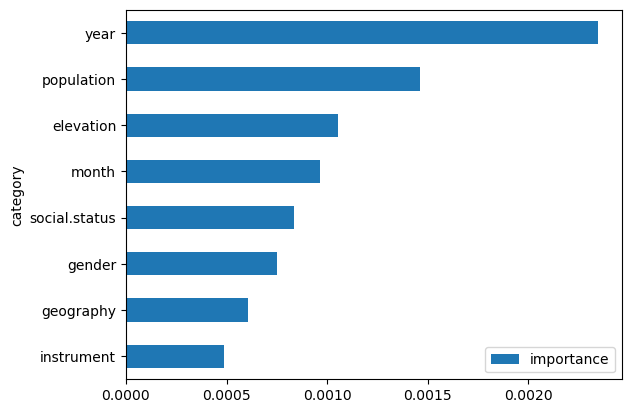

In [25]:
importances[['category','importance']].groupby('category').mean().sort_values(by='importance').plot(kind='barh')

Feature importances: 


<AxesSubplot:>

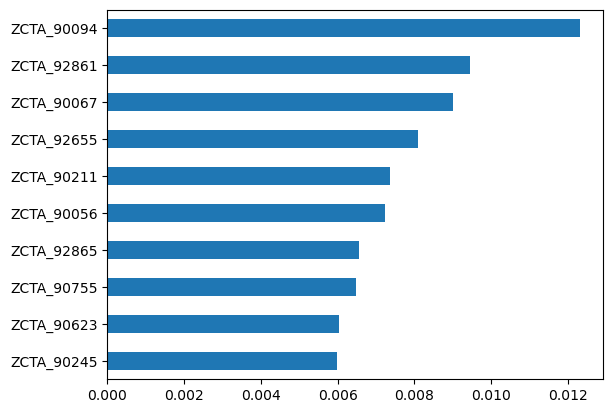

In [26]:
print('Feature importances: ')
feat_importances = pd.Series(best_xgb_model.feature_importances_, 
                             index=best_xgb_model.get_booster().feature_names)
feat_importances.nlargest(10).sort_values().plot(kind='barh')

In [27]:
#feature importance heat map by ZCTA
geos = importances.loc[importances['category']=='geography']
geos['ZCTA'] = geos['variable_name'].apply(lambda x: x.split('_')[1]).astype(int)

#find a way to plot heat map

/tmp/ipykernel_140197/813662553.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  geos['ZCTA'] = geos['variable_name'].apply(lambda x: x.split('_')[1]).astype(int)


#### 5b. Permutation importance

#### 5c. SHAP

## 6. Validation and Residual Plot

In [31]:
X, y = create_stage1_data(instrument_var_name='ins_5_norm_bins_acres')

In [32]:
y_pred = best_xgb_model.predict(X)

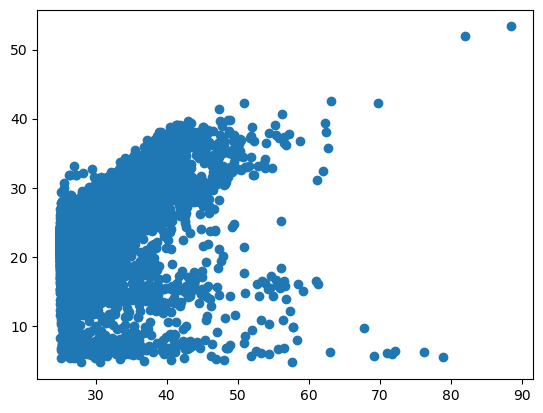

In [47]:
plt.scatter(y[y>25],y_pred[y>25]);
plt.show()

In [48]:
resid = y-y_pred

In [44]:
y_pred[y>30]

array([10.29799  ,  9.972974 ,  7.2669487, ...,  6.305841 ,  8.52755  ,
        6.4847045], dtype=float32)

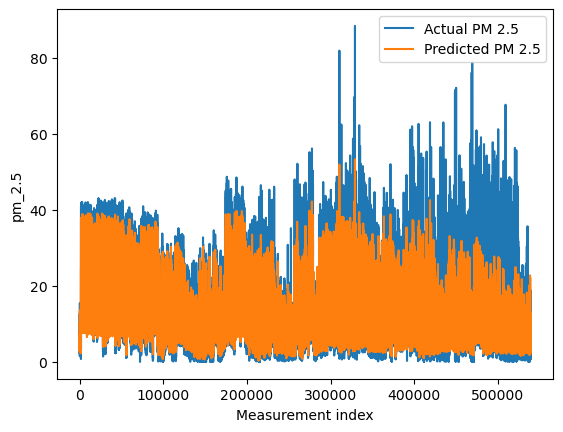

In [53]:
plt.plot(X.index,y)
plt.plot(X.index,y_pred)
plt.xlabel('Measurement index')
plt.ylabel('pm_2.5')
plt.legend(['Actual PM 2.5','Predicted PM 2.5'])
plt.show()

In [73]:
print('Hi Jordan, how are you')

Hi Jordan, how are you
